In [1]:
import math
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Ant Colony Optimization Algorithm for Garbage Truck Routing Optimization

This report aims to explain the implementation of the Ant Colony Optimization (ACO) algorithm for solving the problem of finding the optimal route for a garbage truck given the locations of the trash bins in a KML file. 

### Problem Description
The problem at hand involves determining the most efficient route for a garbage truck to navigate through a specified area's trash bins. The objective is to minimize the total distance traveled by the truck while ensuring that all trash bins are visited exactly once. This problem can be formulated as a combinatorial optimization problem, with the aim of finding the optimal sequence of trash bin visits that minimizes the overall distance.

### Choice of Optimization Algorithm
Among the various optimization algorithms available, the Ant Colony Optimization (ACO) algorithm was selected for this problem due to its suitability and effectiveness. While other algorithms such as Linear Programming, Integer Programming, Nonlinear Programming, Stochastic Methods, Metaheuristics (e.g., Genetic Algorithms), and Dynamic Programming may have potential applicability, ACO stands out for several reasons:

* Generality: ACO is a more generic algorithm that can effectively handle large-scale combinatorial problems. It does not require complete problem knowledge in advance, making it suitable for scenarios where precise knowledge of all garbage bin locations may not be available beforehand.
* Success in TSP-like Problems: ACO has a proven track record of success in solving problems similar to the Traveling Salesman Problem (TSP). Since the garbage truck routing problem shares similarities with TSP, ACO is a promising choice for finding optimal routes in our scenario.


### Problem Solution

1. **Parsing KML File:**

* Provide the path to the KML file you want to parse.
* Call the parse_kml_file function, passing the file path as an argument.
* Capture the returned dictionary of placemark information.
* This step extracts the placemark names and coordinates from the KML file.
* Example:

In [2]:
def parse_kml_file(file_path: str) -> dict:
    placemarks = {}
    try:
        # Parse the KML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find all Placemark elements in the KML
        placemark_elements = root.findall(".//{http://www.opengis.net/kml/2.2}Placemark")

        # Process each Placemark and extract relevant information
        for placemark_element in placemark_elements:
            # Extract the necessary information from the Placemark
            name = placemark_element.find(".//{http://www.opengis.net/kml/2.2}name").text
            coord_string = placemark_element.find(".//{http://www.opengis.net/kml/2.2}coordinates").text

            # Add the placemark to the dictionary with name as the key and [lat, long] list as the value
            placemarks[name] = [float(i) for i in coord_string.split(",")][:2]

    except (ET.ParseError, FileNotFoundError) as e:
        # Handle potential exceptions that may occur during parsing
        print("Error parsing KML file:", e)

    return placemarks

In [3]:
file_path = "Παναγία-Προφήτης Ηλίας.kml"
placemarks = parse_kml_file(file_path)

Extract the names and coordinates of points from the placemarks dictionary and store them in point_names and points variables respectively.

In [4]:
point_names = list(placemarks.keys())
points = np.array(list(placemarks.values()))

Plot the points on a two-dimensional coordinate plane.

* points[:, 0]: This selects the first column of the points array, which represents the x-coordinates of the points. It uses the syntax [:, 0] to select all rows (:) and the column with index 0.

* points[:, 1]: This selects the second column of the points array, which represents the y-coordinates of the points. It uses the syntax [:, 1] to select all rows (:) and the column with index 1.

* plt.scatter(): This function from the Matplotlib library is used to create a scatter plot. It takes the x-coordinates and y-coordinates of the points as its first and second arguments, respectively.

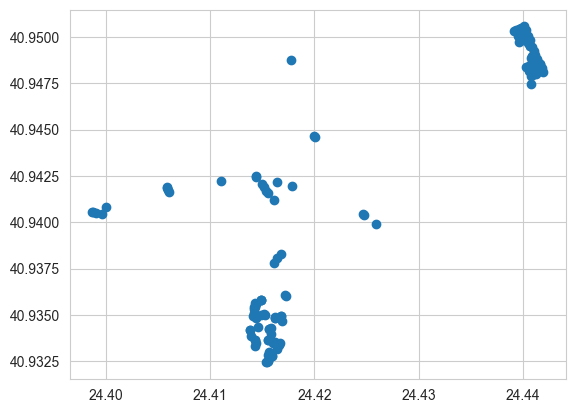

In [5]:
plt.scatter(points[:,0],points[:,1]);

To calculate the Euclidean distance between two points in a two-dimensional space, we will use the following function:

In [6]:
def distance(cords1: list, cords2: list):
    d = (math.sqrt((cords2[0] - cords1[0]) ** 2 + (cords2[1] - cords1[1]) ** 2))
    return round(d, 7)

According to the Ant Colony Optimization (ACO) algorithm, as ants move through space, they leave a pheromone trail behind them. If another ant smells these pheromones, the chances of it following this path are increased by some percentage. The more ants that pass along a path, the more pheromones on the path increase, and the more ants are likely to follow it. This is why we see ants coming and going in a particular line, and this is a function that the ACO algorithm simulates.

In summary, the ACO algorithm works as follows:
Each ant starts from a random point. Which point he chooses as the next on his path depends on three factors:
1. The distance from its neighbouring points.
2. The amount of pheromone in the neighbouring pathways.
3. The luck factor, with the choice for the next point being made.

Here we make a function that calculates a table with the distances between all points.

In [7]:
def distance_matrix(points):
    points_size = points.shape[0]
    dist_mat = np.zeros((points_size, points_size))

    for i in range(points_size):
        for j in range(points_size):
            dist_mat[i, j] = distance(points[i], points[j])

    return dist_mat

By calling the function with the data points of this exercise and drawing a heatmap of the table, we obtain the following illustration. (The black diagonal means that each point is zero distance from itself. )

136


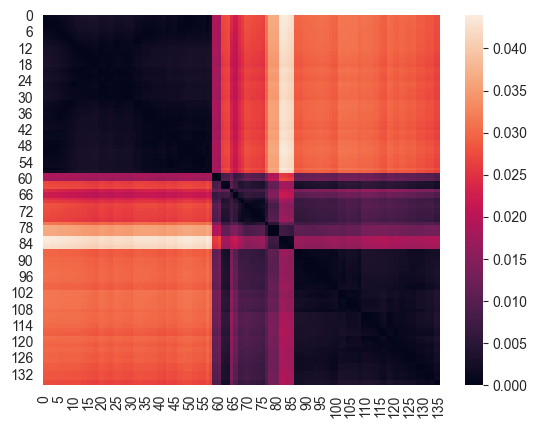

In [8]:
#dist_map demo
import seaborn as sns
print(len(points))
dist_map = distance_matrix(points)
sns.heatmap(dist_map);

The ACO algorithm uses the inverse of the distance, raised to a power $β$, which is a parameter of the method.
We define a function, which constructs the table with the inverse distances.

In [9]:
def inverse_distance_matrix(points):
    points_size = points.shape[0]
    inv_dist_mat = np.zeros((points_size, points_size))

    # first, construct the distance matrix
    dist_mat = distance_matrix(points)

    for i in range(points_size):
        for j in range(points_size):
            if i == j:
                pass
            else:
                inv_dist_mat[i, j] = 1.0 / dist_mat[i, j]

    return inv_dist_mat

By calling the function with the data points of this exercise and drawing a heatmap of the table, we obtain the following illustration. 

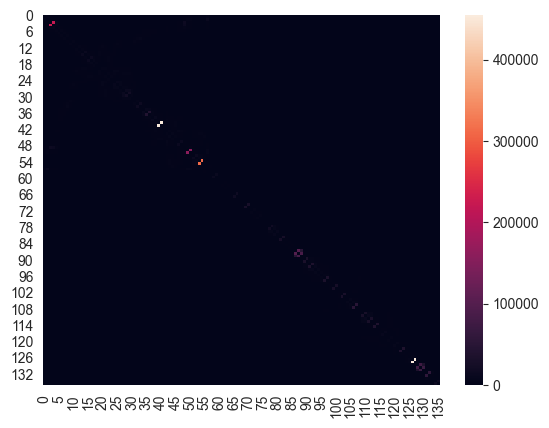

In [10]:
inv_dist_mat = inverse_distance_matrix(points)

sns.heatmap(inv_dist_mat)

We define a 'class' Ant, which represents each ant and contains the following variables:

* n_locations: the number of node-points in the problem.
* position: the node-point where the ant is at the given moment.
* places_visited: list of places where the ant has passed by.
* places_left: list of places where the ant has not yet passed.
* tour_cost: the total length of the route the ant has travelled so far.
* phero_graph: a table with the amount of pheromone corresponding to each possible pair of points in the network.

In addition, Ant also contains the following functions:

* ant_trip: performs one complete trip for each ant (in each iteration of the algorithm).
* ant_flush: rebuilds the object data (so that it is ready for the next iteration).

In [11]:
class Ant:
    def __init__(self, n_locations):
        self.position = None
        self.n_locations = n_locations
        self._initialize()

    def ant_trip(self, g_phero_graph, dist_mat, inv_dist_mat, alpha=1, beta=1, q=1):
        for _ in range(len(self.places_left)):
            # Pick next destination
            next_destination = self.get_next_destination(g_phero_graph, inv_dist_mat, alpha, beta)
            # Add distance into total distance travelled
            self.tour_cost += dist_mat[self.position, next_destination]
            # Change current position and update travel-log variables
            self.position = next_destination
            self.places_visited.append(next_destination)
            self.places_left.remove(next_destination)

        self.update_pheromone_graph(q)

    def get_next_destination(self, g_phero_graph, inv_dist_mat, alpha, beta):
        places_left_indices = list(self.places_left)  # Convert set to a list of indices
        numerator = (g_phero_graph[self.position, places_left_indices] ** alpha) * \
                    (inv_dist_mat[self.position, places_left_indices] ** beta)
        probability = numerator / np.sum(numerator)
        return np.random.choice(places_left_indices, p=probability)

    def update_pheromone_graph(self, q):
        for i, j in zip(self.places_visited[:-1], self.places_visited[1:]):
            self.phero_graph[i, j] = q / self.tour_cost

    def _initialize(self):
        self.position = np.random.choice(self.n_locations)
        self.places_left = set(range(self.n_locations))
        self.places_left.remove(self.position)
        self.places_visited = [self.position]
        self.phero_graph = np.zeros((self.n_locations, self.n_locations))
        self.tour_cost = 0.0

    def flush(self):
        self._initialize()

As we have seen, the chances of choosing the next point in an ant's path depend on the amount of pheromone present in each part of the path. These quantities are stored in a table, which will be updated every time an ant completes a journey. 

This update takes into account:

* the sequence of points that make up the route.
* the total length of the route (the shorter the better, so more pheromone is deposited to make the route look attractive to other ants).
* the pheromone evaporation coefficient (acts as a "memory" of the system).

We now write the pheromone renewal function:

In [12]:
def update_pheromones(g_phero_graph, ants, evapo_coef=0.05):
    dim = g_phero_graph.shape[0]

    for i in range(dim):
        for j in range(dim):
            g_phero_graph[i, j] = (1 - evapo_coef) * g_phero_graph[i, j] + np.sum(
                [ant.phero_graph[i, j] for ant in ants])
            g_phero_graph[i, j] = max(g_phero_graph[i, j], 1e-08)  # avoid division by zero

    return g_phero_graph

We now write the main algorithm in function form, which takes the following arguments:

* points: the coordinate points [x,y] between which we are asked to find the optimal route.
* alpha: coefficient that determines how big a role the pheromone will play in the choice of the path (a larger *a* means that we look more and more at what path the other ants have formed).
* beta: a coefficient that determines how much the distance between points will play a role in the choice of the path (a larger *b* means that the ant is more likely to choose the closest point from the point it is at).
* evapo_coef: pheromone evaporation coefficient.
* Q: parameter related to pheromone strength (used mainly for scaling between pheromone and distance)
* colony_size: total number of ants.
* num_iter: total number of iterations.

In [13]:
def aco(points, alpha, beta, evapo_coef, colony_size, num_iter):
    # compute (once) the distance matrices
    dist_mat = distance_matrix(points)
    inv_dist_mat = inverse_distance_matrix(points)

    n_locations = points.shape[0]  # total number of points
    ants = [Ant(n_locations) for _ in range(colony_size)]  # ant colony

    # determine initial pheromone value
    phero_init = (inv_dist_mat.mean()) ** (beta / alpha)
    g_phero_graph = np.full((n_locations, n_locations), phero_init)  # pheromone matrix (arbitrary initialization)

    # determine scaling coefficient "Q"
    [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, 1) for ant in ants]
    best_ant = np.argmin([ant.tour_cost for ant in ants])  # ant that scored best in this iteration
    q = ants[best_ant].tour_cost * phero_init / (0.1 * colony_size)

    best_path_length = ants[best_ant].tour_cost
    best_path = ants[best_ant].places_visited.copy()

    monitor_costs = []

    for _ in tqdm(np.arange(num_iter)):

        [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, q) for ant in ants]
        g_phero_graph = update_pheromones(g_phero_graph, ants, evapo_coef).copy()

        iteration_winner = np.argmin([ant.tour_cost for ant in ants])  # ant that scored best in this iteration
        best_path_iteration = ants[iteration_winner].places_visited

        # update global best if better
        if best_path_length > ants[iteration_winner].tour_cost:
            best_path = best_path_iteration.copy()
            best_path_length = ants[iteration_winner].tour_cost

        monitor_costs.append(best_path_length)

        [ant.flush() for ant in ants]

    return best_path, monitor_costs


function for plotting the result:


In [14]:
def plot_map(points, best_path, monitor_costs):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(points[best_path, 0],
             points[best_path, 1])

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(monitor_costs)), monitor_costs)

    plt.show()



Example of usage:

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


0.11895119999999999


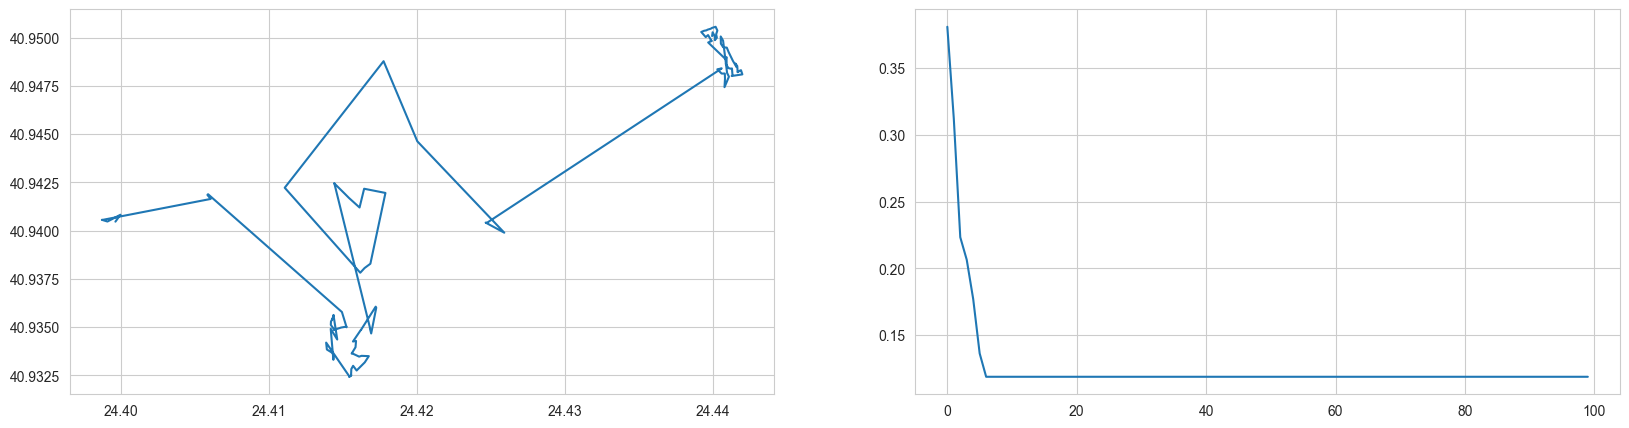

['1965' '1964' '1960' '1959' '1958' '1956' '1955' '1954' '1953' '1948'
 '1949' '1989' '1988' '1987' '1986' '1985' '1984' '1983' '1982' '1994'
 '1990' '1995' '1980' '1981' '1993' '1991' '1992' '1977' '1979' '1978'
 '1976' '1950' '1951' '1952' '1973' '1974' '1975' '1971' '1972' '1938'
 '1939' '1940' '1970' '1947' '1942' '1941' '1969' '1968' '1957' '1961'
 '1962' '1967' '1966' '1945' '1946' '1943' '1963' '1944' '1936' '1937'
 '1935' '1928' '1929' '1930' '1932' '1934' '1933' '1927' '1926' '1919'
 '1920' '1921' '1922' '1923' '1924' '1925' '1931' '1868' '1867' '1866'
 '1865' '1863' '1864' '1862' '1860' '1861' '1869' '1870' '1871' '1882'
 '1881' '1879' '1880' '1878' '1877' '1884' '1875' '1876' '1874' '1873'
 '1872' '1889' '1890' '1891' '1885' '1886' '1887' '1888' '1883' '1893'
 '1892' '1895' '1894' '1898' '1899' '1900' '1901' '1902' '1896' '1897'
 '1904' '1903' '1906' '1905' '1907' '1908' '1909' '1910' '1911' '1913'
 '1912' '1917' '1918' '1916' '1914' '1915']


In [15]:
# Parse the KML file and get the dictionary of placemarks
placemarks = parse_kml_file("Παναγία-Προφήτης Ηλίας.kml")

point_names = list(placemarks.keys())
points = np.array(list(placemarks.values()))

best_path_order, monitor_costs = aco(
    points=points,
    alpha=1,
    beta=1,
    evapo_coef=0.05,
    colony_size=50,
    num_iter=100
)
print(monitor_costs[-1])

plot_map(points, best_path_order, monitor_costs)

sorted_point_names = np.array(point_names)[np.argsort(best_path_order)]

print(sorted_point_names)